<a href="https://colab.research.google.com/github/gnodking7/PINN-California-Delta/blob/main/PINN_vs_ANN_Chrono_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal is to demonstrate the advantage of PINN (Physics-informed neural network) over ANN (fully-connected) in estimating salinity in California-Delta estuary.

Although both models use the same NN (same structure and same number of hyperparameters, except the input layer) and the same data (train and validation), **PINN achieves higher accuracy than ANN**.

The main difference between ANN model and PINN model is illustrated by the following NN structure:

1.   ANN

![](https://drive.google.com/uc?id=1pPT0dd_v91PRnfj7lw8aLIzWZu0T9Rcu)

*   The input of ANN is the outflow vector $\vec{Q}_n$ corresponding to day $n$.
*   ANN is trained by minimizing the mean squared error $$\sum_n\|\hat{S}_n-S_n\|^2$$ where $\hat{S}_n$ is the output of ANN and $S_n$ is the true salinity value.

2.   PINN

![](https://drive.google.com/uc?id=1Z77TmoPzrmUN3SdADFWhaD22KXC9LY5f)

*   The input of PINN is the outflow vector $\vec{Q}_n$ **and** location $x_n$ and time $t_n$.
*   PINN is trained by minimizing the mean squared error **and** PDE(1D Advection Dispersion eq) loss $$\sum_n\|\hat{S}_n-S_n\|^2 +\sum_n\bigg\|A\frac{\partial \hat{S}}{\partial t}\Bigr|_{(x_n,t_n)}-\vec{Q}_{n,1}\frac{\partial \hat{S}}{\partial x}\Bigr|_{(x_n,t_n)}-KA\frac{\partial^2 \hat{S}}{\partial x^2}\Bigr|_{(x_n,t_n)}\bigg\|^2$$ where $\vec{Q}_{n,1}$ is the first component of the outflow vector $\vec{Q}_n$.

Daily outflow and salinity data from 1991 to 2017 are chronologically split in two schemes:

*   Train: 1991-2011, Test: 2012-2017
*   Train: 1997-2017, Test: 1991-1996



# Preliminary Setup


## Install Packages

In [1]:
!pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 144 kB 6.0 MB/s 
     |████████████████████████████████| 100 kB 9.8 MB/s 


In [1]:
import numpy as np
import matplotlib.pylab as pl
import deepxde as dde
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import sys
import os

Using backend: tensorflow.compat.v1

Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



## Read Data

### Read outflow and salinity data

In [2]:
### OPTIONAL, if mount manually by tab on left which is less work actually ###
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

In [3]:
gdrive_root_path = os.path.join('/content/drive','My Drive','PINN')
sys.path.append(gdrive_root_path)

In [4]:
sys.path.append('/content/drive/My Drive/MAC/Python')

'''
The data is in an Excel file.
Daily DSM2 outflow and salinity at locations:
  Martinez  Port Chicago  Chipps Island
from Apr 1 1990 to Dec 28 2017
'''
df = pd.read_excel("/content/drive/My Drive/MAC/Python/PortChicago202210.xlsx", header=None)
All = np.asarray(df)
All = All[7:, :]  # Discard headers

for i in range(len(All)):
    All[i, 1] = str(All[i, 1])  # Change dates to str

In [5]:
def data_pre(year, daily, window, window_len):
    """
    Returns preprocessed outflow data for a given 'year' at locations
    Martinez, Port Chicago, Chipps Island such that
    to each day corresponds outflow data of length 'daily' + 'window'

    The preprocessed outflow data vector is created such that
    first 'daily' number of outflow (including current day) is included
    and prior 'window_len' many outflows are averaged 'window' many times

    PARAMETERS
    ----------
    year :        string or array of strings
                  Outflow year(s)
    daily :       int
                  number of outflow to include 'as-is'
    window :      int
                  number of average windows in return outflow
    window_len :  int
                  length of each window
    RETURNS
    -------
    M_OUT :       ndarray, shape (year length, daily+window)
                  Preprocessed outflow at Martinez
    P_OUT :       ndarray, shape (year length, daily+window)
                  Preprocessed outflow at Port Chicago
    C_OUT :       ndarray, shape (year length, daily+window)
                  Preprocessed outflow at Chipps Island
    """

    if type(year) == str:
        indices = numpy.flatnonzero(numpy.core.defchararray.find(list(All[:, 1]), year)!=-1)
    else:
        indices = []
        for yr in year:
            indices.extend(numpy.flatnonzero(numpy.core.defchararray.find(list(All[:, 1]), yr)!=-1))
    total = daily + window * window_len
    OUT_d = All[indices[0] - (total - 1):indices[-1] + 1, 2:5] # Range of outflow to extract outflow vector from
    OUT_d = np.flip(OUT_d, 1) # Locations are in reverse order, so flip data
    OUT_d = (OUT_d - np.min(OUT_d)) / (np.max(OUT_d) - np.min(OUT_d)) # Normalize

    ## Preprocessed outflow data for Martinez
    M_OUT = []
    cur = total - 1
    for i in range(len(indices)):
        vec = OUT_d[cur-(daily-1):cur+1, 0]
        vec = np.flip(vec)
        ind = cur - (daily - 1)
        for j in range(window):
            avg = np.mean(OUT_d[ind-window_len:ind, 0])
            vec = np.concatenate((vec, np.array([avg])))
            ind -= window_len
        M_OUT.append(vec)
        cur += 1
    M_OUT = np.array(M_OUT)

    ## Preprocessed outflow data for Port Chicago
    P_OUT = []
    cur = total - 1
    for i in range(len(indices)):
        vec = OUT_d[cur-(daily-1):cur+1, 1]
        vec = np.flip(vec)
        ind = cur - (daily - 1)
        for j in range(window):
            avg = np.mean(OUT_d[ind-window_len:ind, 1])
            vec = np.concatenate((vec, np.array([avg])))
            ind -= window_len
        P_OUT.append(vec)
        cur += 1
    P_OUT = np.array(P_OUT)

    ## Preprocessed outflow data for Chipps Island
    C_OUT = []
    cur = total - 1
    for i in range(len(indices)):
        vec = OUT_d[cur-(daily-1):cur+1, 2]
        vec = np.flip(vec)
        ind = cur - (daily - 1)
        for j in range(window):
            avg = np.mean(OUT_d[ind-window_len:ind, 2])
            vec = np.concatenate((vec, np.array([avg])))
            ind -= window_len
        C_OUT.append(vec)
        cur += 1
    C_OUT = np.array(C_OUT)

    return M_OUT, P_OUT, C_OUT

### Preprocess to create outflow vectors

In [6]:
years = ['1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']

indices = []
for yr in years:
    indices.extend(np.flatnonzero(np.core.defchararray.find(list(All[:, 1]), yr)!=-1))
indices = np.array(indices)

EC_d = All[indices, 5:] # Salinity at three locations
EC_min = np.min(EC_d)
EC_max = np.max(EC_d)

'''
Create outflow data vectors at each location
To each day corresponds a 18-dim vector created from antecedent 118 outflow data:
  current day + previous 7 days + previous 110 days averaged into 10-dim values with window length 11
'''
M_OUT, P_OUT, C_OUT = data_pre(years, 8, 10, 11)

### Split to train and validation

In [17]:
tr_years = ['1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']
# tr_years = ['1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011']
tst_years = ['1991','1992','1993','1994','1995','1996']
# tst_years = ['2012','2013','2014','2015','2016','2017']

tr_indices = []
for yr in tr_years:
    tr_indices.extend(np.flatnonzero(np.core.defchararray.find(list(All[:, 1]), yr)!=-1))
tr_indices = np.array(tr_indices)

tst_indices = []
for yr in tst_years:
    tst_indices.extend(np.flatnonzero(np.core.defchararray.find(list(All[:, 1]), yr)!=-1))
tst_indices = np.array(tst_indices)

In [19]:
## Training data
tr_EC_d = All[tr_indices, 5:]
tr_EC_d = np.flip(tr_EC_d, 1)
tr_EC_d = (tr_EC_d - EC_min) / (EC_max - EC_min) # Normalize

Q = []  # Inputs for ANN
X = []  # Inputs for PINN
Svals = []  # Outputs (same for both ANN and PINN)

portion = 1 / (len(tr_indices) + len(tst_indices)) # to split the time domain [0, 1] uniformly

for i in range(len(tr_EC_d)):
    cur_ind = tr_indices[i]
    for j in range(3):
        # Martinez
        if j == 0:
            Q.append(M_OUT[cur_ind-275, :])
            X.append(np.concatenate(([0, (cur_ind - 274) * portion], M_OUT[cur_ind-275, :])))
        # Port Chicago
        elif j == 1:
            Q.append(P_OUT[cur_ind-275, :])
            X.append(np.concatenate(([0.442, (cur_ind - 274) * portion], P_OUT[cur_ind-275, :])))
        # Chipps Island
        elif j == 2:
            Q.append(C_OUT[cur_ind-275, :])
            X.append(np.concatenate(([1, (cur_ind - 274) * portion], C_OUT[cur_ind-275, :])))
        Svals.append(tr_EC_d[i, j])

Q = np.array(Q).astype('float32')
X = np.array(X).astype('float32')
Svals = np.array(Svals).astype('float32').flatten()[:, None]

## Testing data
tst_EC_d = All[tst_indices, 5:]
tst_EC_d = np.flip(tst_EC_d, 1)
tst_EC_d = (tst_EC_d - EC_min) / (EC_max - EC_min) # Normalize

Q_tst = []  # Validation inputs for ANN
X_tst = []  # Validation inputs for PINN
Svals_tst = []  # Validation outputs

for i in range(len(tst_EC_d)):
    cur_ind = tst_indices[i]
    for j in range(3):
        # Martinez
        if j == 0:
            Q_tst.append(M_OUT[cur_ind-275, :])
            X_tst.append(np.concatenate(([0, (cur_ind - 274) * portion], M_OUT[cur_ind-275, :])))
        # Port Chicago
        elif j == 1:
            Q_tst.append(P_OUT[cur_ind-275, :])
            X_tst.append(np.concatenate(([0.442, (cur_ind - 274) * portion], P_OUT[cur_ind-275, :])))
        # Chipps Island
        elif j == 2:
            Q_tst.append(C_OUT[cur_ind-275, :])
            X_tst.append(np.concatenate(([1, (cur_ind - 274) * portion], C_OUT[cur_ind-275, :])))
        Svals_tst.append(tst_EC_d[i, j])

Q_tst = np.array(Q_tst).astype('float32')
X_tst = np.array(X_tst).astype('float32')
Svals_tst = np.array(Svals_tst).astype('float32').flatten()[:, None]

## Define Evaluation Metrics

In [9]:
## Evaluation metrics
from collections import defaultdict
eval_metrics = ['MSE', 'Bias', 'R', 'RMSD', 'NSE', 'L2']

def evaluate_sequences(target, pred, metrics):
    assert len(target) == len(pred), 'Target and predicted sequence length must equal.'
    valid_entries = target>0
    sequence_length = np.sum(valid_entries)
    if np.any(sequence_length == 0):
        return {k: 0 for k in metrics}
    target=target[valid_entries]
    pred = pred[valid_entries]
    SD_pred = np.sqrt( np.sum((pred-np.mean(pred)) ** 2) /(sequence_length-1))
    SD_target = np.sqrt( np.sum((target-np.mean(target)) ** 2) /(sequence_length-1))

    eval_results = defaultdict(float)
    
    for m in metrics:
        if m =='MSE':
            eval_results[m] = ((target - pred)**2).mean()
        elif m =='Bias':
            eval_results[m] = np.sum(pred - target)/np.sum(target) * 100
        elif m == 'R':
            eval_results[m] = np.sum(np.abs((pred-np.mean(pred)) * (target - np.mean(target)))) / (sequence_length * SD_pred * SD_target)
        elif m == 'RMSD':
            eval_results[m] = np.sqrt(np.sum( ( ( pred-np.mean(pred) ) * ( target - np.mean(target) ) ) ** 2 ) / sequence_length)
        elif m == 'NSE':
            eval_results[m] = 1 - np.sum( ( target - pred ) ** 2 ) / np.sum( (target - np.mean(target) ) ** 2 )
        elif m == 'L2':
            eval_results[m] = dde.metrics.l2_relative_error(target, pred)
    return eval_results

# Train PINN

## Train: 1997-2017, Test: 1991-1996

Optimal parameters found by random search using Keras Tuner

Hyperparameters:
*   activation_1: tanh
*   activation_2: relu
*   activation_3: elu
*   nhidden1: 24
*   nhidden2: 2








### Train model

In [39]:
## Geometry
geom = dde.geometry.geometry_nd.Hypercube(xmin=[0] * 20, xmax=[1] * 20)

## PDE
def pde(x, y):
    A = 0.002
    K = 133.959
    S = y
    Q = x[:, 2:3]
    dS_x = dde.grad.jacobian(S, x, i=0, j=0)
    dS_t = dde.grad.jacobian(S, x, i=0, j=1)
    dS_xx = dde.grad.hessian(S, x, i=0, j=0)
    return A * dS_t - Q * dS_x - K * A * dS_xx

## Data
observe_S = dde.icbc.PointSetBC(X, Svals, component=0)

data = dde.data.TimePDE(geom, pde, [observe_S], num_domain=10000, num_boundary=100, anchors=X)

## Neural Network
activation = ["tanh", "relu", "elu"]
net = dde.nn.FNN([20, 24, 2, 1], activation, kernel_initializer="Glorot normal")

## Model
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

## Train
losshistory, train_state = model.train(epochs=50000, callbacks=[dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)])

Compiling model...
Building feed-forward neural network...
'build' took 0.073614 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.846726 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.86e-03, 7.82e-01]    [1.86e-03, 7.82e-01]    []  
1000      [2.16e-04, 5.02e-03]    [2.16e-04, 5.02e-03]    []  
2000      [1.28e-04, 3.58e-03]    [1.28e-04, 3.58e-03]    []  
3000      [5.77e-05, 3.14e-03]    [5.77e-05, 3.14e-03]    []  
4000      [4.52e-05, 2.97e-03]    [4.52e-05, 2.97e-03]    []  
5000      [4.80e-05, 2.91e-03]    [4.80e-05, 2.91e-03]    []  
6000      [4.04e-05, 2.55e-03]    [4.04e-05, 2.55e-03]    []  
7000      [3.50e-05, 2.46e-03]    [3.50e-05, 2.46e-03]    []  
8000      [3.37e-05, 2.41e-03]    [3.37e-05, 2.41e-03]    []  
9000      [3.38e-05, 2.37e-03]    [3.38e-05, 2.37e-03]    []  
10000     [3.36e-05, 2.37e-03]    [3.36e-05, 2.37e-03]    []  
Epoch 10000: early stopping

Best model at step 9000:
  train loss: 2.40e-03
  test loss: 2.40e-03
  test metric: []

'train' took 61.167043 s



In [37]:
## Save model
model_path_prefix = "PINN_chrono_last2"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
model.save(model_savepath)
print('Model saved to %s' % model_savepath)

Model saved to /content/drive/My Drive/PINN/models/PINN_chrono_last2


### Evaluate model & Generate plots

In [35]:
## Evaluation results
train_results = evaluate_sequences(Svals, model.predict(X), eval_metrics)
test_results = evaluate_sequences(Svals_tst, model.predict(X_tst), eval_metrics)

print("PINN results for training")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])
print("\n")
print("PINN results for testing")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

PINN results for training
------------------------------
MSE : 0.0025480788
Bias : 0.33119150903075933
R : 0.9846015537817047
RMSD : 0.09733384279440013
NSE : 0.9665753357112408
L2 : 0.10366709


PINN results for testing
------------------------------
MSE : 0.0072400216
Bias : 10.63530296087265
R : 0.9777973420382282
RMSD : 0.11201734296264457
NSE : 0.9172044098377228
L2 : 0.16887547


PINN results for testing at Martinez
------------------------------
MSE : 0.009532716485432139
Bias : 11.473730977799649
R : 0.9784868685196701
RMSD : 0.12869196621749235
NSE : 0.903844674175582
L2 : 0.17263118106928563
PINN results for training at Martinez
------------------------------
MSE : 0.0032760390839843495
Bias : -0.024367562743177886
R : 0.9820968925464961
RMSD : 0.11053786282735194
NSE : 0.9618246123682761
L2 : 0.1033121489030485
PINN results for testing at Port Chicago
------------------------------
MSE : 0.00543322867711289
Bias : 10.145185487266115
R : 0.9795940207157491
RMSD : 0.08522484131225924
NSE : 0.923375761704479
L2 : 0.16823923129139137
PINN results for training at Port Chicago
------------------------------
MSE : 0.0018726232041026334
Bias : 1.029279624564867
R : 0.9856095587358119
RMSD : 0.07450599948513406
NSE : 0.9688879495092625
L2 : 0.10456241953055606
PINN results for testing at Chipps Island
------------------------------
MSE : 0.00675411976607525
Bias : 

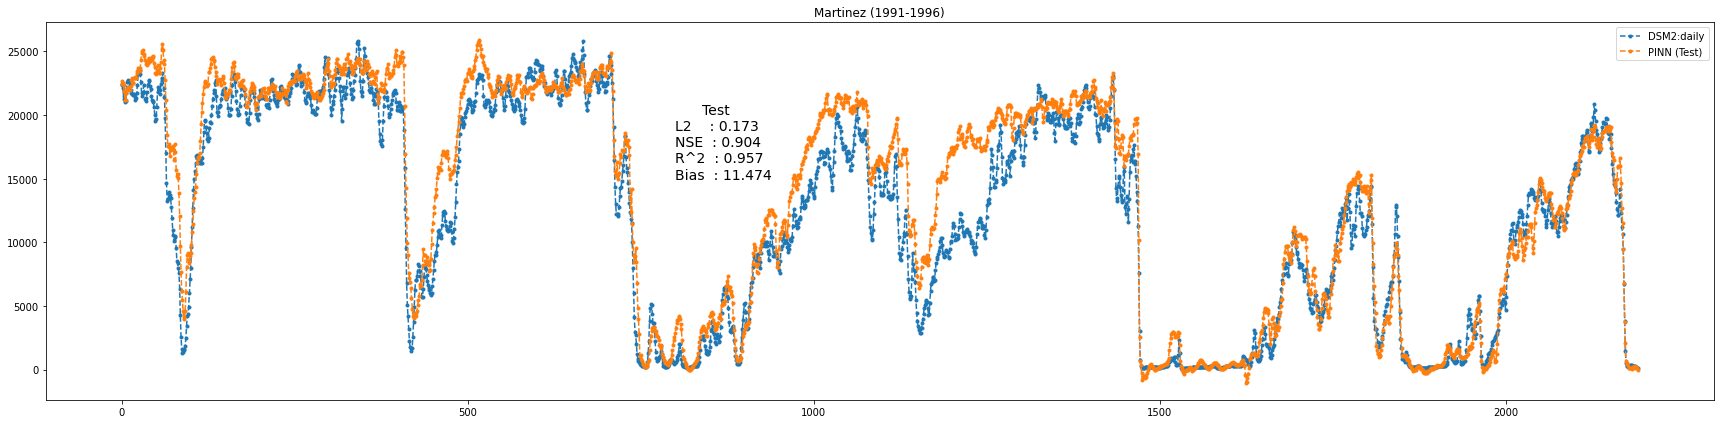

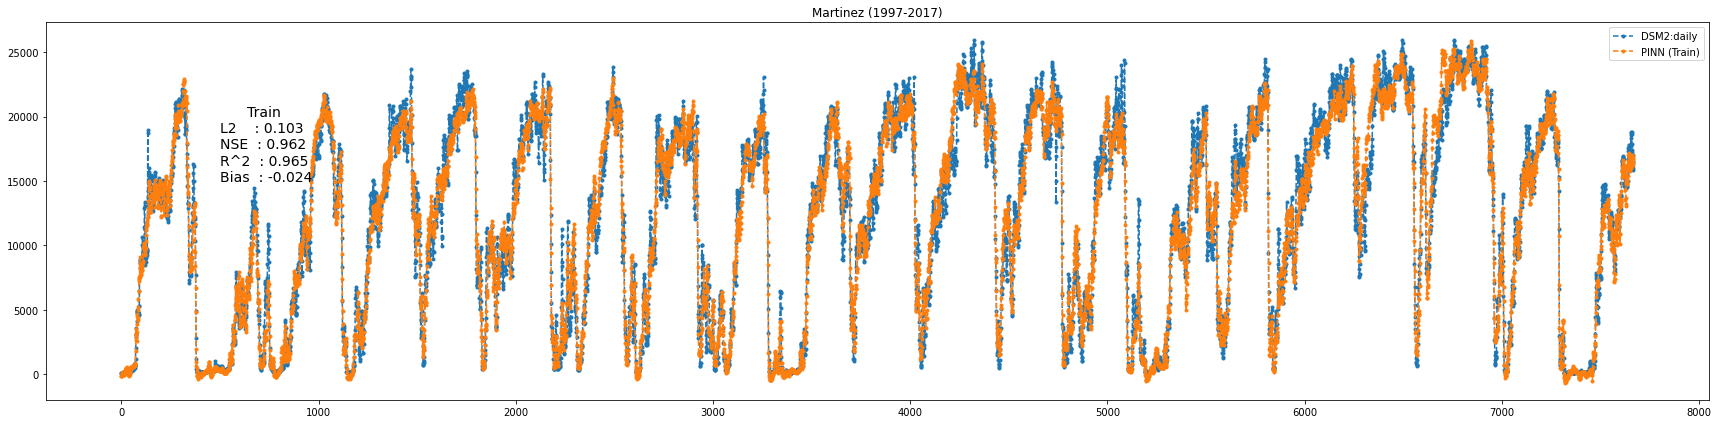

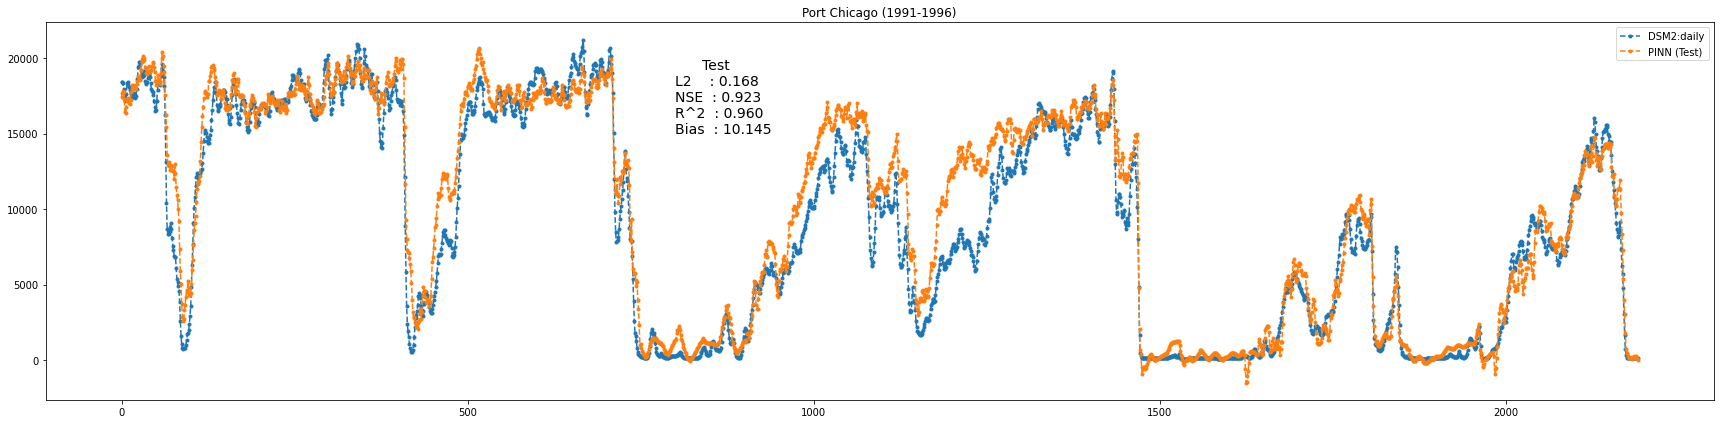

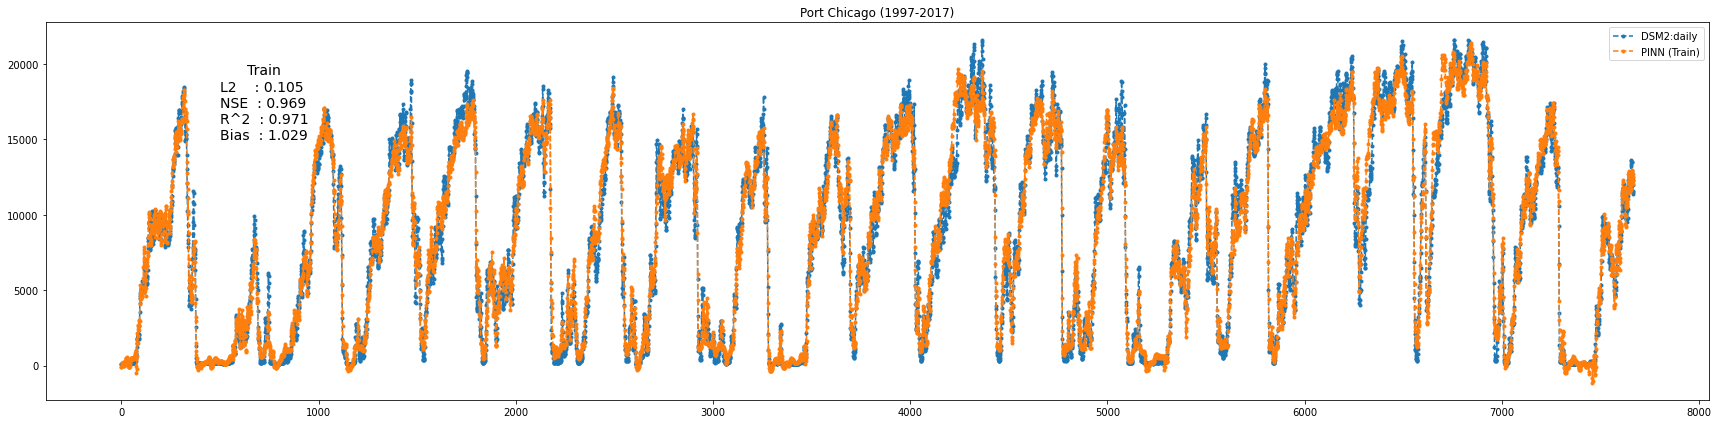

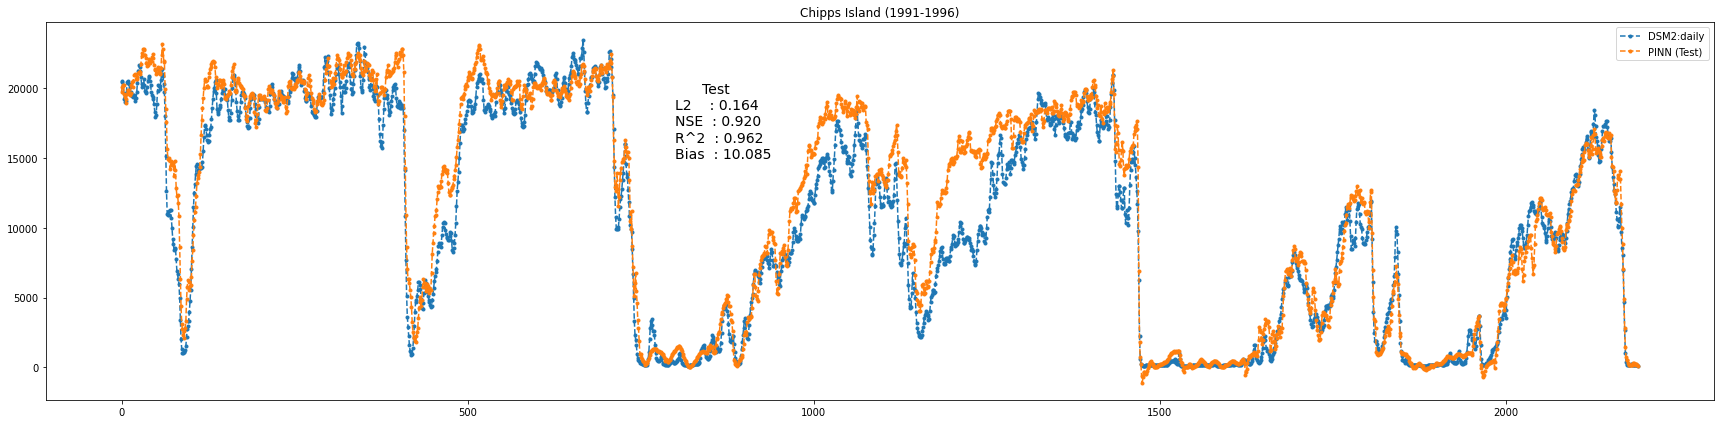

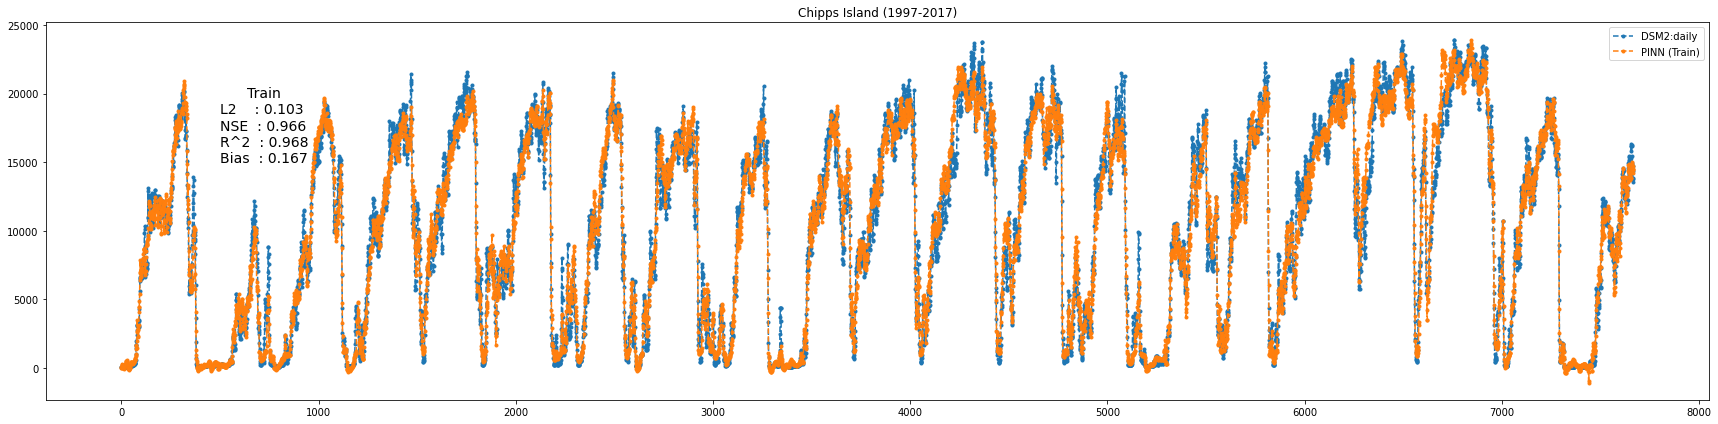

In [36]:
'''
Plot time series of salinity estimated by PINN at three locations
'''

portion = 1 / (len(tr_indices) + len(tst_indices)) # to split the time domain [0, 1] uniformly

## At Martinez

# Test plot
P = []

for i in range(len(tst_EC_d)):
    cur_ind = tst_indices[i]
    P.append(np.concatenate(([0, (cur_ind - 274) * portion], M_OUT[cur_ind-275, :])))

P = np.array(P)

test_results = evaluate_sequences(tst_EC_d[:, 0][:, None], model.predict(P), eval_metrics)
print("PINN results for testing at Martinez")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

fig1 = pl.figure(1, figsize=(24,6))
pl.plot(tst_EC_d[:, 0] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='PINN (Test)')
pl.text(800, 15000, '      Test\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (test_results['L2'], test_results['NSE'], test_results['R']**2, test_results['Bias']), fontsize=14)
pl.legend()
pl.title('Martinez (1991-1996)')
pl.tight_layout()

# Train plot
P = []

for i in range(len(tr_EC_d)):
    cur_ind = tr_indices[i]
    P.append(np.concatenate(([0, (cur_ind - 274) * portion], M_OUT[cur_ind-275, :])))

P = np.array(P)

train_results = evaluate_sequences(tr_EC_d[:, 0][:, None], model.predict(P), eval_metrics)
print("PINN results for training at Martinez")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])

fig2 = pl.figure(2, figsize=(24,6))
pl.plot(tr_EC_d[:, 0] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='PINN (Train)')
pl.text(500, 15000, '      Train\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (train_results['L2'], train_results['NSE'], train_results['R']**2, train_results['Bias']), fontsize=14)
pl.legend()
pl.title('Martinez (1997-2017)')
pl.tight_layout()

## At Port Chicago

# Test plot
P = []

for i in range(len(tst_EC_d)):
    cur_ind = tst_indices[i]
    P.append(np.concatenate(([0.442, (cur_ind - 274) * portion], P_OUT[cur_ind-275, :])))

P = np.array(P)

test_results = evaluate_sequences(tst_EC_d[:, 1][:, None], model.predict(P), eval_metrics)
print("PINN results for testing at Port Chicago")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

fig3 = pl.figure(3, figsize=(24,6))
pl.plot(tst_EC_d[:, 1] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='PINN (Test)')
pl.text(800, 15000, '      Test\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (test_results['L2'], test_results['NSE'], test_results['R']**2, test_results['Bias']), fontsize=14)
pl.legend()
pl.title('Port Chicago (1991-1996)')
pl.tight_layout()

# Train plot
P = []

for i in range(len(tr_EC_d)):
    cur_ind = tr_indices[i]
    P.append(np.concatenate(([0.442, (cur_ind - 274) * portion], P_OUT[cur_ind-275, :])))

P = np.array(P)

train_results = evaluate_sequences(tr_EC_d[:, 1][:, None], model.predict(P), eval_metrics)
print("PINN results for training at Port Chicago")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])

fig4 = pl.figure(4, figsize=(24,6))
pl.plot(tr_EC_d[:, 1] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='PINN (Train)')
pl.text(500, 15000, '      Train\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (train_results['L2'], train_results['NSE'], train_results['R']**2, train_results['Bias']), fontsize=14)
pl.legend()
pl.title('Port Chicago (1997-2017)')
pl.tight_layout()

## At Chipps Island

# Test plot
P = []

for i in range(len(tst_EC_d)):
    cur_ind = tst_indices[i]
    P.append(np.concatenate(([1, (cur_ind - 274) * portion], C_OUT[cur_ind-275, :])))

P = np.array(P)

test_results = evaluate_sequences(tst_EC_d[:, 2][:, None], model.predict(P), eval_metrics)
print("PINN results for testing at Chipps Island")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

fig5 = pl.figure(5, figsize=(24,6))
pl.plot(tst_EC_d[:, 2] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='PINN (Test)')
pl.text(800, 15000, '      Test\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (test_results['L2'], test_results['NSE'], test_results['R']**2, test_results['Bias']), fontsize=14)
pl.legend()
pl.title('Chipps Island (1991-1996)')
pl.tight_layout()

# Train plot
P = []

for i in range(len(tr_EC_d)):
    cur_ind = tr_indices[i]
    P.append(np.concatenate(([1, (cur_ind - 274) * portion], C_OUT[cur_ind-275, :])))

P = np.array(P)

train_results = evaluate_sequences(tr_EC_d[:, 2][:, None], model.predict(P), eval_metrics)
print("PINN results for training at Chipps Island")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])

fig6 = pl.figure(6, figsize=(24,6))
pl.plot(tr_EC_d[:, 2] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='PINN (Train)')
pl.text(500, 15000, '      Train\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (train_results['L2'], train_results['NSE'], train_results['R']**2, train_results['Bias']), fontsize=14)
pl.legend()
pl.title('Chipps Island (1997-2017)')
pl.tight_layout()

In [38]:
fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Martinez_test")
fig1.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Martinez_train")
fig2.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Port Chicago_test")
fig3.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Port Chicago_train")
fig4.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Chipps Island_test")
fig5.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Chipps Island_train")
fig6.savefig(fig_savepath, bbox_inches='tight',dpi=300)

### ANN for comparison

Same hyperparameters as PINN

In [205]:
## Train model

model = keras.Sequential(
        [
            keras.layers.Input(shape=(18,)),
            keras.layers.Dense(24, activation='tanh'),
            keras.layers.Dense(2, activation='relu'),
            keras.layers.Dense(1, activation='elu')
        ])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

history = model.fit(Q, Svals,
                        epochs=5000,
                        batch_size=len(Q),
                        validation_data=(Q_tst, Svals_tst),
                        callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                patience=50,
                                                                mode="min",
                                                                restore_best_weights=True),
                                ],
                    )

Train on 23001 samples, validate on 6576 samples
Epoch 1/5000
23001/23001 [==============================] - ETA: 0s - loss: 0.2374

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


23001/23001 [==============================] - 5s 229us/sample - loss: 0.2374 - val_loss: 0.2525
Epoch 2/5000
23001/23001 [==============================] - 0s 1us/sample - loss: 0.2358 - val_loss: 0.2502
Epoch 3/5000
23001/23001 [==============================] - 0s 1us/sample - loss: 0.2335 - val_loss: 0.2468
Epoch 4/5000
23001/23001 [==============================] - 0s 1us/sample - loss: 0.2301 - val_loss: 0.2425
Epoch 5/5000
23001/23001 [==============================] - 0s 1us/sample - loss: 0.2257 - val_loss: 0.2372
Epoch 6/5000
23001/23001 [==============================] - 0s 1us/sample - loss: 0.2205 - val_loss: 0.2316
Epoch 7/5000
23001/23001 [==============================] - 0s 1us/sample - loss: 0.2150 - val_loss: 0.2257
Epoch 8/5000
23001/23001 [==============================] - 0s 1us/sample - loss: 0.2093 - val_loss: 0.2198
Epoch 9/5000
23001/23001 [==============================] - 0s 1us/sample - loss: 0.2036 - val_loss: 0.2139
Epoch 10/5000
23001/23001 [============

In [29]:
## Save model
model_path_prefix = "ANN_chrono_last2"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
model.save(model_savepath)
print('Model saved to %s' % model_savepath)

Model saved to /content/drive/My Drive/PINN/models/ANN_chrono_last2


In [202]:
## Load model (if saved already)
# model_path_prefix = "ANN_chrono_last2"
# model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
# model = keras.models.load_model(model_savepath)

In [206]:
## Evaluation results

train_results = evaluate_sequences(Svals, model.predict(Q), eval_metrics)
test_results = evaluate_sequences(Svals_tst, model.predict(Q_tst), eval_metrics)

print("ANN results for training")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])
print("\n")
print("ANN results for testing")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


ANN results for training
------------------------------
MSE : 0.009260387
Bias : -1.3005908578634262
R : 0.9462649439515689
RMSD : 0.0896163903095264
NSE : 0.8785259947180748
L2 : 0.19762823


ANN results for testing
------------------------------
MSE : 0.010280521
Bias : 1.5971343964338303
R : 0.9528325550309795
RMSD : 0.09980453359042107
NSE : 0.8824338018894196
L2 : 0.20123534


ANN results for testing at Martinez
------------------------------
MSE : 0.011572864980324405
Bias : -11.70384480998802
R : 0.9678181376126972
RMSD : 0.10904099806999808
NSE : 0.8832659499938286
L2 : 0.19020912448457572
ANN results for training at Martinez
------------------------------
MSE : 0.012624923307039975
Bias : -15.743783346201859
R : 0.9648136891602087
RMSD : 0.09756680060325797
NSE : 0.852882908685915
L2 : 0.20281087189818006
ANN results for testing at Port Chicago
------------------------------
MSE : 0.011946751527053755
Bias : 19.08936777222023
R : 0.9605041503358283
RMSD : 0.08911098091747295
NSE : 0.8315162511523851
L2 : 0.24947279846684503
ANN results for training at Port Chicago
------------------------------
MSE : 0.009565534633675198
Bias : 18.744180564541765
R : 0.9615617722835573
RMSD : 0.07975476814727246
NSE : 0.841076733513823
L2 : 0.2363224868150245
ANN results for testing at Chipps Island
------------------------------
MSE : 0.007321948366621608
Bias : 1.99899

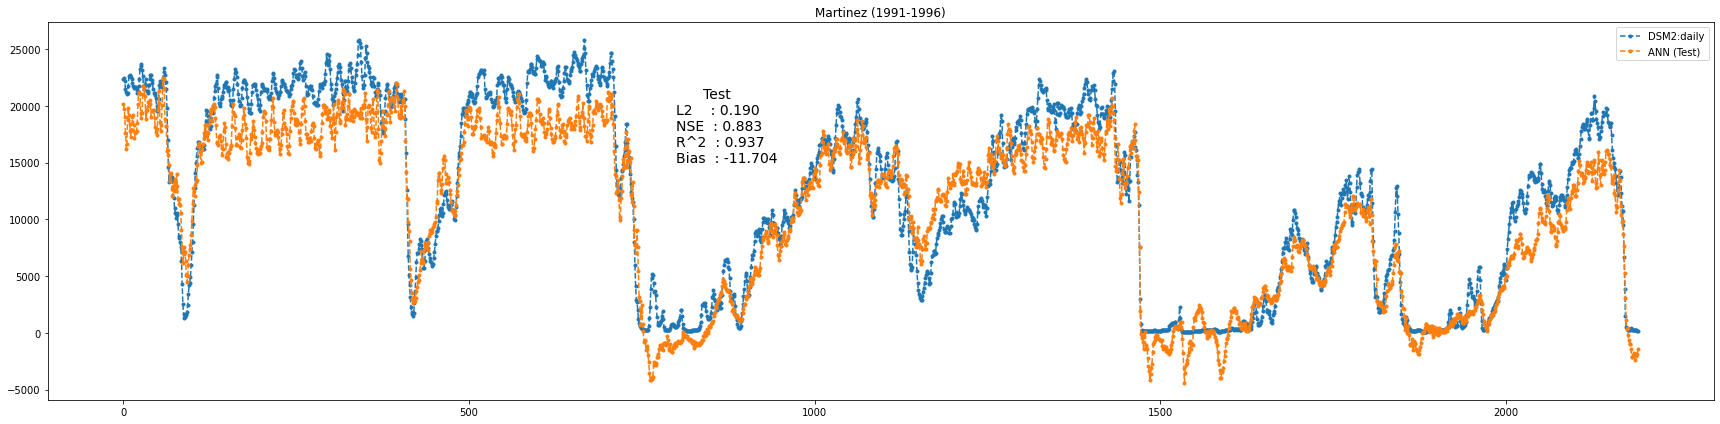

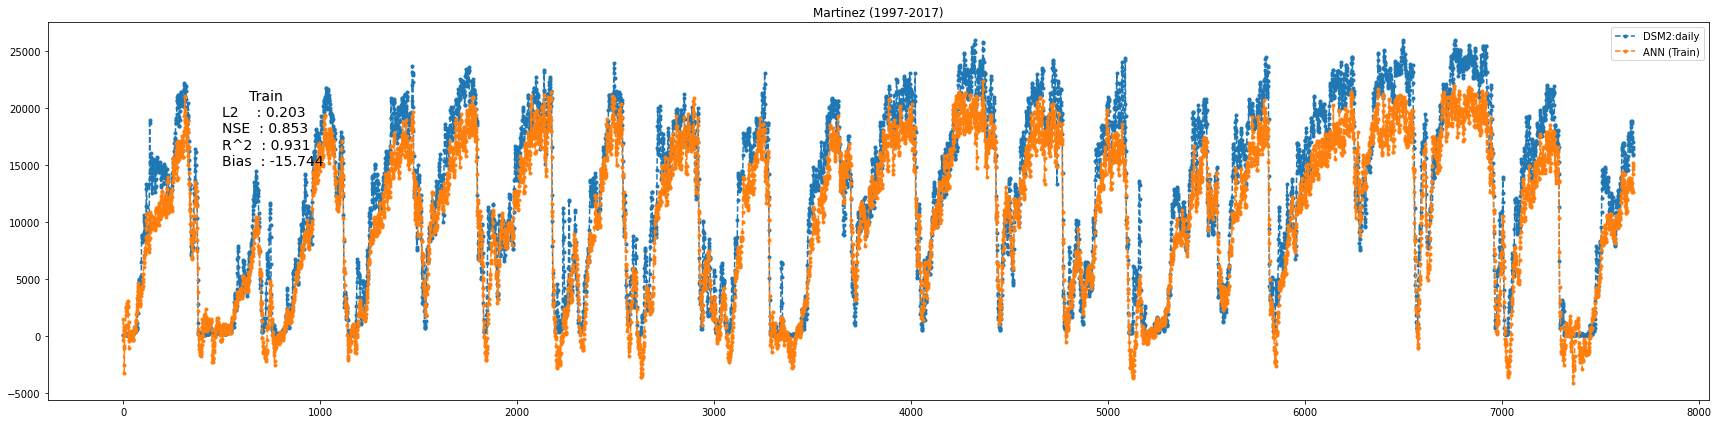

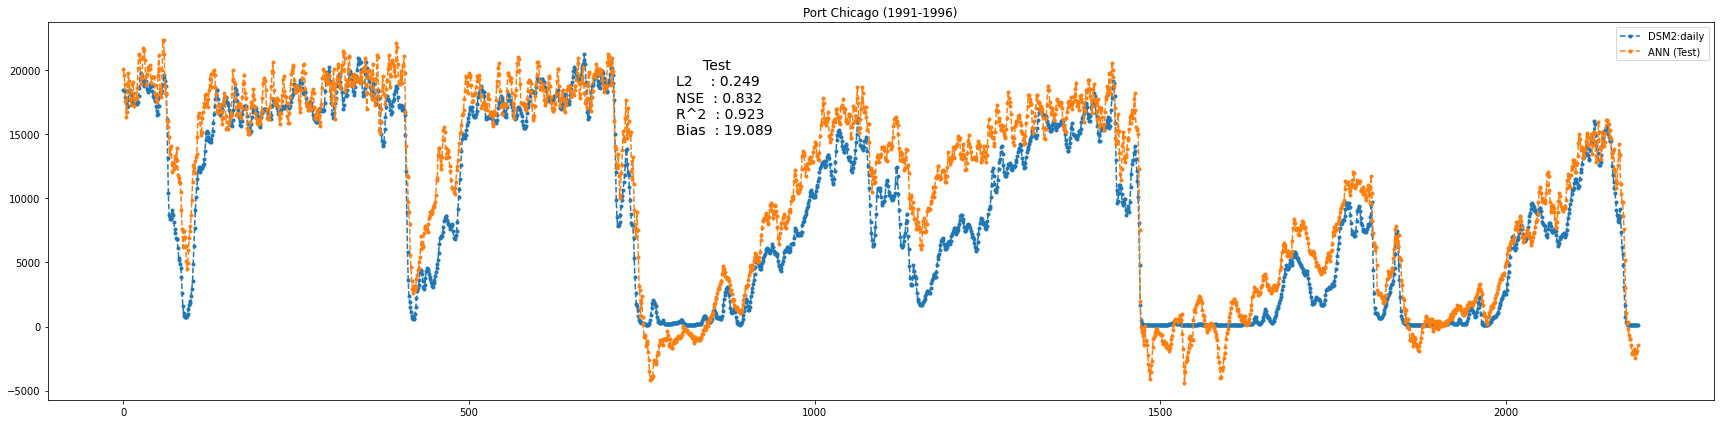

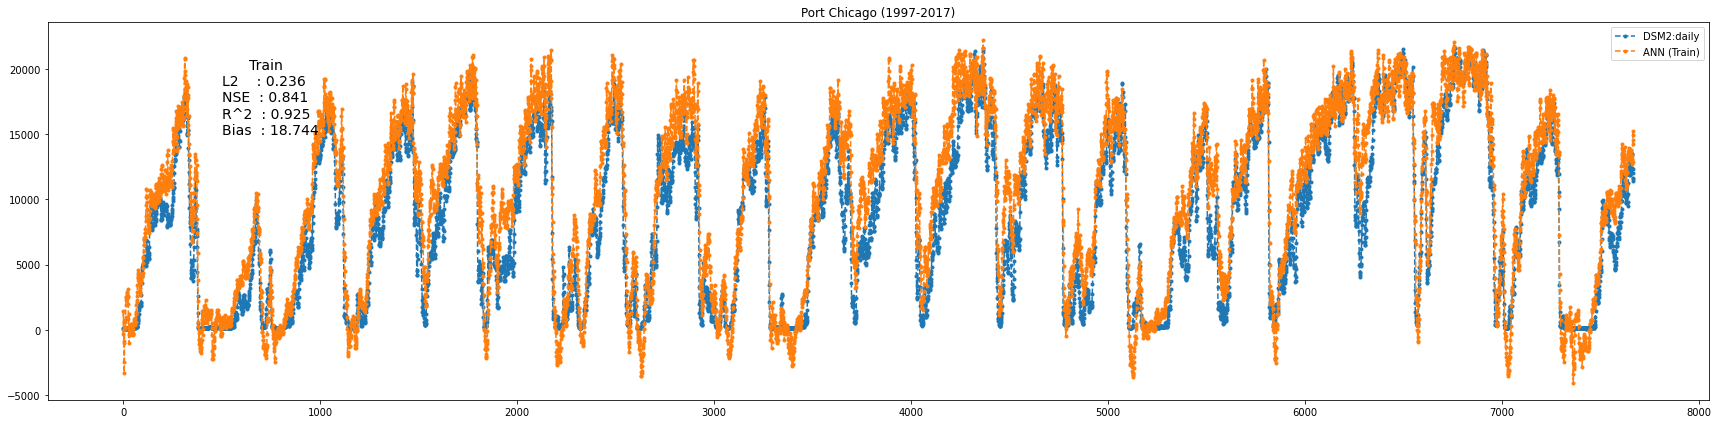

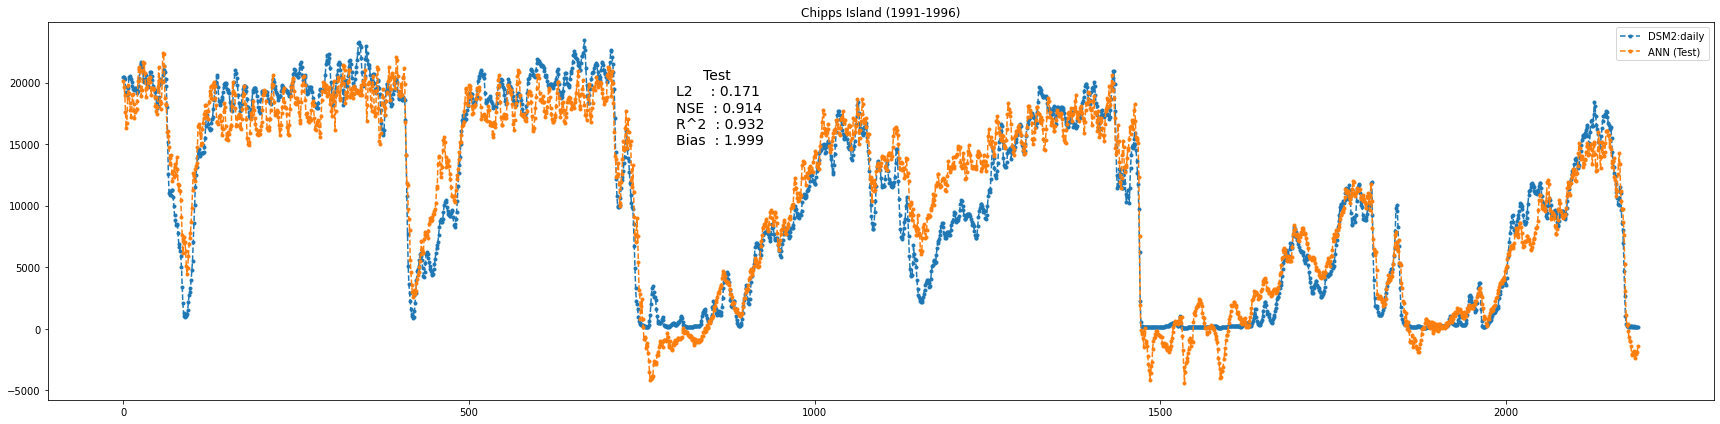

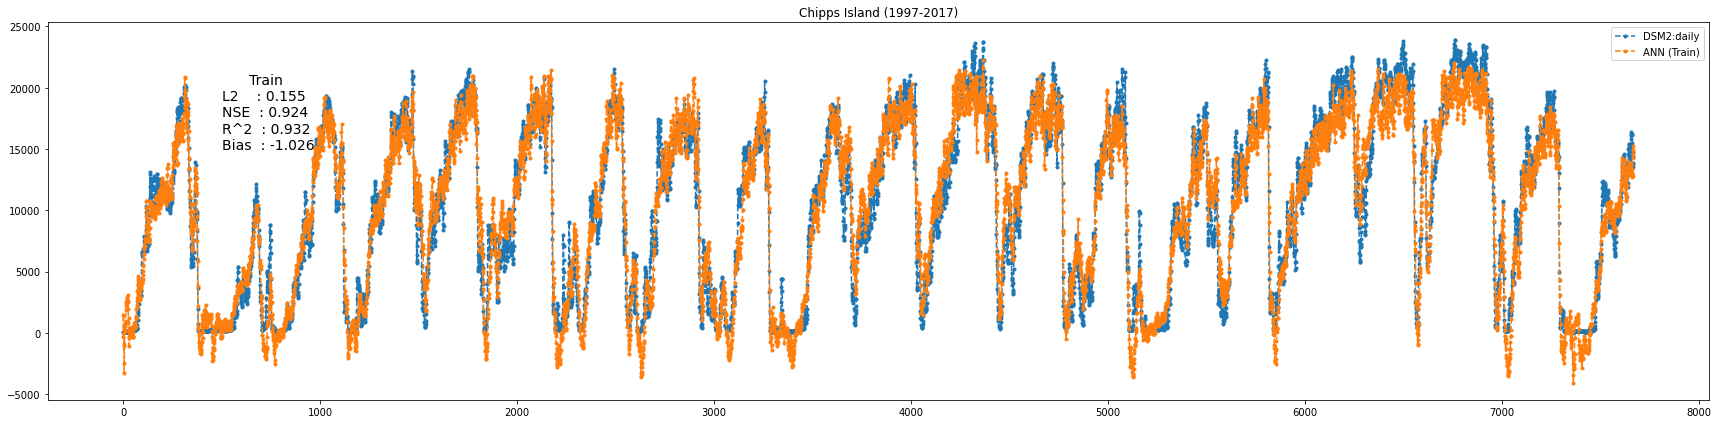

In [207]:
'''
Plot time series of salinity estimated by ANN at three locations
'''

## At Martinez

# Test plot
P = []

for i in range(len(tst_EC_d)):
    cur_ind = tst_indices[i]
    P.append(M_OUT[cur_ind-275, :])

P = np.array(P)

test_results = evaluate_sequences(tst_EC_d[:, 0][:, None], model.predict(P), eval_metrics)
print("ANN results for testing at Martinez")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

fig1 = pl.figure(1, figsize=(24,6))
pl.plot(tst_EC_d[:, 0] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='ANN (Test)')
pl.text(800, 15000, '      Test\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (test_results['L2'], test_results['NSE'], test_results['R']**2, test_results['Bias']), fontsize=14)
pl.legend()
pl.title('Martinez (1991-1996)')
pl.tight_layout()

# Train plot
P = []

for i in range(len(tr_EC_d)):
    cur_ind = tr_indices[i]
    P.append(M_OUT[cur_ind-275, :])

P = np.array(P)

train_results = evaluate_sequences(tr_EC_d[:, 0][:, None], model.predict(P), eval_metrics)
print("ANN results for training at Martinez")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])

fig2 = pl.figure(2, figsize=(24,6))
pl.plot(tr_EC_d[:, 0] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='ANN (Train)')
pl.text(500, 15000, '      Train\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (train_results['L2'], train_results['NSE'], train_results['R']**2, train_results['Bias']), fontsize=14)
pl.legend()
pl.title('Martinez (1997-2017)')
pl.tight_layout()

## At Port Chicago

# Test plot
P = []

for i in range(len(tst_EC_d)):
    cur_ind = tst_indices[i]
    P.append(P_OUT[cur_ind-275, :])

P = np.array(P)

test_results = evaluate_sequences(tst_EC_d[:, 1][:, None], model.predict(P), eval_metrics)
print("ANN results for testing at Port Chicago")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

fig3 = pl.figure(3, figsize=(24,6))
pl.plot(tst_EC_d[:, 1] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='ANN (Test)')
pl.text(800, 15000, '      Test\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (test_results['L2'], test_results['NSE'], test_results['R']**2, test_results['Bias']), fontsize=14)
pl.legend()
pl.title('Port Chicago (1991-1996)')
pl.tight_layout()

# Train plot
P = []

for i in range(len(tr_EC_d)):
    cur_ind = tr_indices[i]
    P.append(P_OUT[cur_ind-275, :])

P = np.array(P)

train_results = evaluate_sequences(tr_EC_d[:, 1][:, None], model.predict(P), eval_metrics)
print("ANN results for training at Port Chicago")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])

fig4 = pl.figure(4, figsize=(24,6))
pl.plot(tr_EC_d[:, 1] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='ANN (Train)')
pl.text(500, 15000, '      Train\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (train_results['L2'], train_results['NSE'], train_results['R']**2, train_results['Bias']), fontsize=14)
pl.legend()
pl.title('Port Chicago (1997-2017)')
pl.tight_layout()

## At Chipps Island

# Test plot
P = []

for i in range(len(tst_EC_d)):
    cur_ind = tst_indices[i]
    P.append(C_OUT[cur_ind-275, :])

P = np.array(P)

test_results = evaluate_sequences(tst_EC_d[:, 2][:, None], model.predict(P), eval_metrics)
print("ANN results for testing at Chipps Island")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

fig5 = pl.figure(5, figsize=(24,6))
pl.plot(tst_EC_d[:, 2] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='ANN (Test)')
pl.text(800, 15000, '      Test\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (test_results['L2'], test_results['NSE'], test_results['R']**2, test_results['Bias']), fontsize=14)
pl.legend()
pl.title('Chipps Island (1991-1996)')
pl.tight_layout()

# Train plot
P = []

for i in range(len(tr_EC_d)):
    cur_ind = tr_indices[i]
    P.append(C_OUT[cur_ind-275, :])

P = np.array(P)

train_results = evaluate_sequences(tr_EC_d[:, 2][:, None], model.predict(P), eval_metrics)
print("ANN results for training at Chipps Island")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])

fig6 = pl.figure(6, figsize=(24,6))
pl.plot(tr_EC_d[:, 2] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='ANN (Train)')
pl.text(500, 15000, '      Train\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (train_results['L2'], train_results['NSE'], train_results['R']**2, train_results['Bias']), fontsize=14)
pl.legend()
pl.title('Chipps Island (1997-2017)')
pl.tight_layout()

In [103]:
## Save plots

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Martinez_test")
fig1.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Martinez_train")
fig2.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Port Chicago_test")
fig3.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Port Chicago_train")
fig4.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Chipps Island_test")
fig5.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Chipps Island_train")
fig6.savefig(fig_savepath, bbox_inches='tight',dpi=300)

## Train: 1991-2011, Test: 2012-2017

Optimal parameters found by random search using Keras Tuner

Hyperparameters:
*   activation_1: relu
*   activation_2: elu
*   activation_3: sigmoid
*   nhidden1: 28
*   nhidden2: 6

### Train model

In [10]:
## Geometry
geom = dde.geometry.geometry_nd.Hypercube(xmin=[0] * 20, xmax=[1] * 20)

## PDE
def pde(x, y):
    A = 0.002
    K = 133.959
    S = y
    Q = x[:, 2:3]
    dS_x = dde.grad.jacobian(S, x, i=0, j=0)
    dS_t = dde.grad.jacobian(S, x, i=0, j=1)
    dS_xx = dde.grad.hessian(S, x, i=0, j=0)
    return A * dS_t - Q * dS_x - K * A * dS_xx

# Data
observe_S = dde.icbc.PointSetBC(X, Svals, component=0)

data = dde.data.TimePDE(geom, pde, [observe_S], num_domain=10000, num_boundary=100, anchors=X)

## Neural Network
activation = ["relu", "elu", "sigmoid"]
net = dde.nn.FNN([20, 28, 6, 1], activation, kernel_initializer="Glorot normal")

## Model
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

## Train
losshistory, train_state = model.train(epochs=50000, callbacks=[dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)])

Compiling model...
Building feed-forward neural network...
'build' took 0.052359 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.749875 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [7.90e-04, 3.03e-01]    [7.90e-04, 3.03e-01]    []  
1000      [2.77e-04, 4.07e-03]    [2.77e-04, 4.07e-03]    []  
2000      [2.26e-04, 2.83e-03]    [2.26e-04, 2.83e-03]    []  
3000      [2.04e-04, 2.61e-03]    [2.04e-04, 2.61e-03]    []  
4000      [1.89e-04, 2.48e-03]    [1.89e-04, 2.48e-03]    []  
5000      [1.90e-04, 2.38e-03]    [1.90e-04, 2.38e-03]    []  
6000      [1.88e-04, 2.32e-03]    [1.88e-04, 2.32e-03]    []  
7000      [1.86e-04, 2.29e-03]    [1.86e-04, 2.29e-03]    []  
8000      [1.83e-04, 2.23e-03]    [1.83e-04, 2.23e-03]    []  
Epoch 8000: early stopping

Best model at step 8000:
  train loss: 2.42e-03
  test loss: 2.42e-03
  test metric: []

'train' took 39.500023 s



In [13]:
## Save model
model_path_prefix = "PINN_chrono_first"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
model.save(model_savepath)
print('Model saved to %s' % model_savepath)

Model saved to /content/drive/My Drive/PINN/models/PINN_chrono_first


### Evaluate model & Generate plots

In [11]:
## Evaluation results

train_results = evaluate_sequences(Svals, model.predict(X), eval_metrics)
test_results = evaluate_sequences(Svals_tst, model.predict(X_tst), eval_metrics)

print("PINN results for training")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])
print("\n")
print("PINN results for testing")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

PINN results for training
------------------------------
MSE : 0.0022333958
Bias : 0.8288397453725338
R : 0.9866902527815685
RMSD : 0.0955312729379555
NSE : 0.9706362653523684
L2 : 0.10112454


PINN results for testing
------------------------------
MSE : 0.0042468277
Bias : 5.161193013191223
R : 0.9795011527411218
RMSD : 0.10625959142293116
NSE : 0.9455412663519382
L2 : 0.115307756


PINN results for testing at Martinez
------------------------------
MSE : 0.00457558519405066
Bias : 3.7719338712167714
R : 0.978778351919706
RMSD : 0.12183339004840571
NSE : 0.9458448774320163
L2 : 0.10649553997043312
PINN results for training at Martinez
------------------------------
MSE : 0.0029154619353207074
Bias : -0.06817557054899719
R : 0.9850122143030947
RMSD : 0.1073191629922384
NSE : 0.9663796283458336
L2 : 0.10148330139919413
PINN results for testing at Port Chicago
------------------------------
MSE : 0.003972943001882867
Bias : 7.516466876824183
R : 0.9785334258544032
RMSD : 0.08427941360027896
NSE : 0.9378574293330822
L2 : 0.12900903909423883
PINN results for training at Port Chicago
------------------------------
MSE : 0.0016404598614316245
Bias : 2.0702070799422
R : 0.9878529811255026
RMSD : 0.0748296710980503
NSE : 0.9725649447727062
L2 : 0.10191414848805984
PINN results for testing at Chipps Island
------------------------------
MSE : 0.0041919548348965975
Bias : 4.

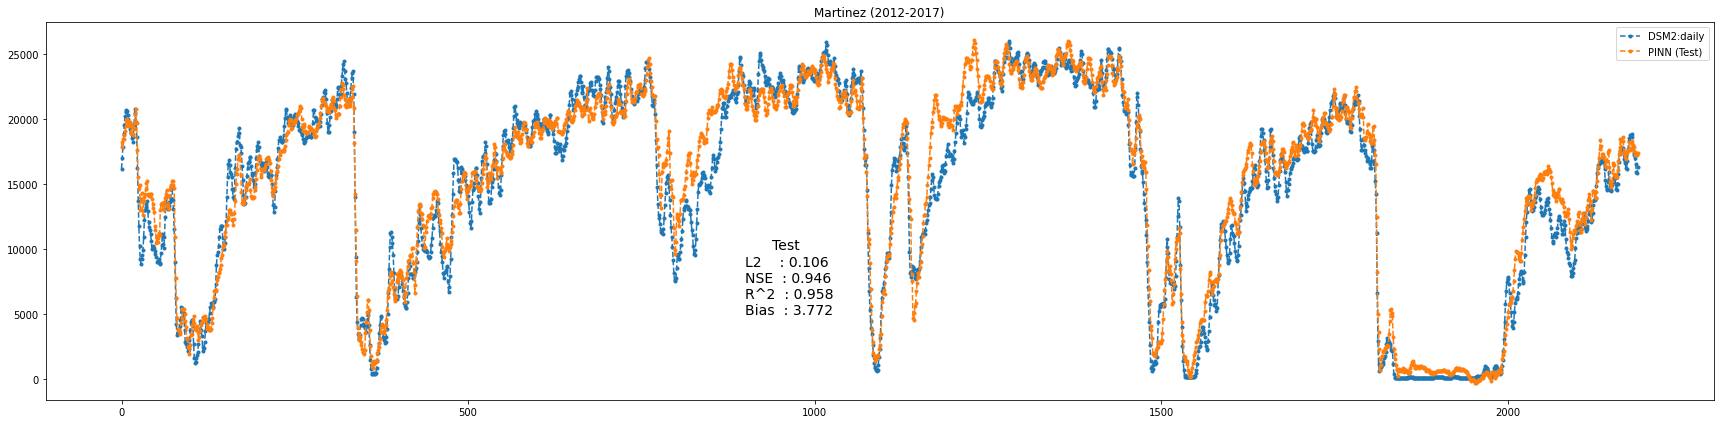

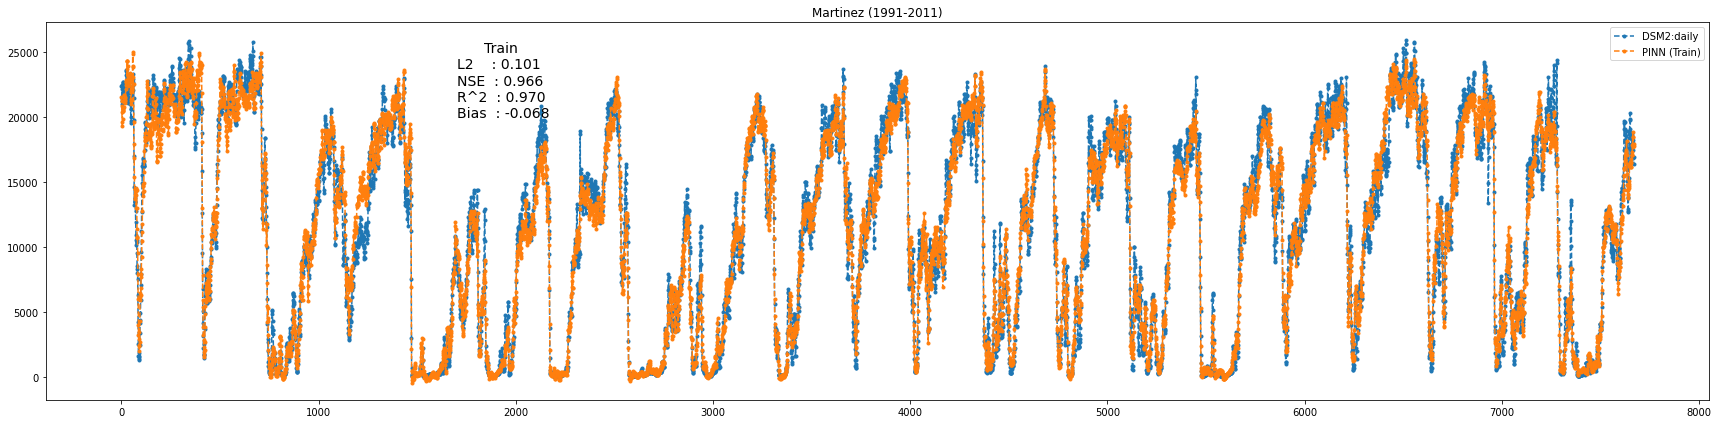

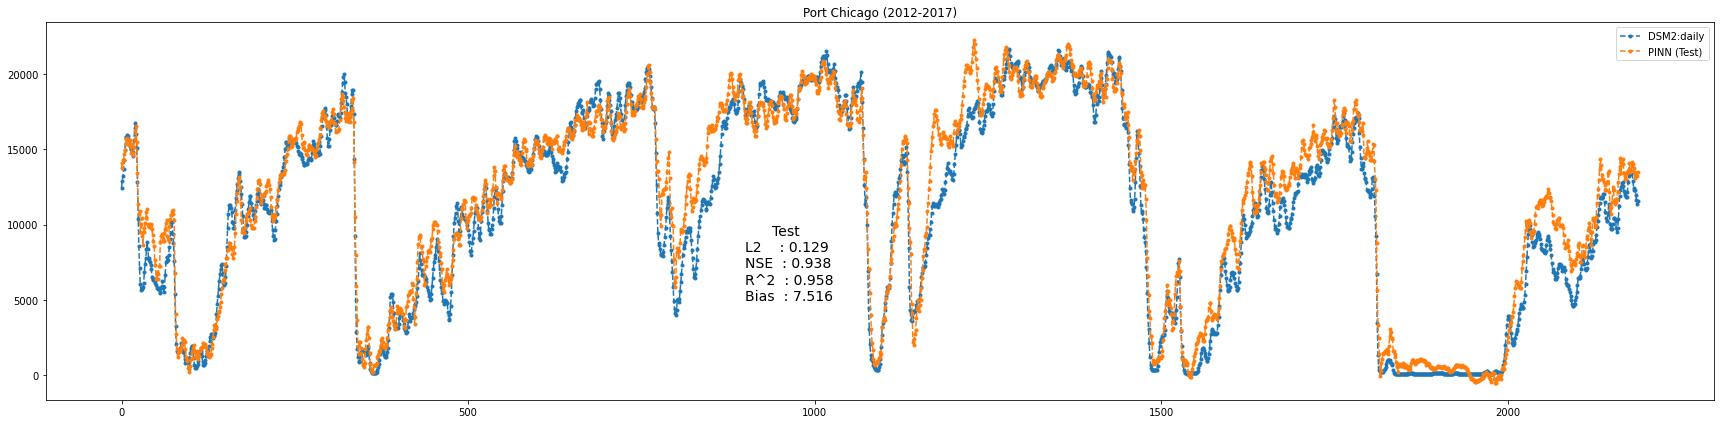

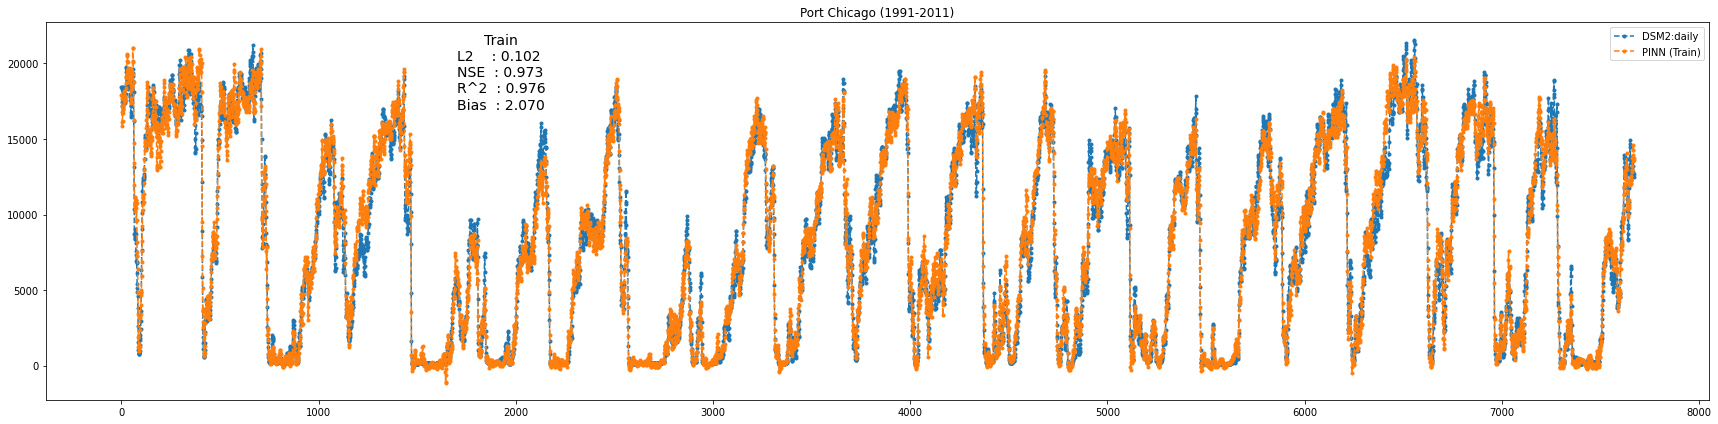

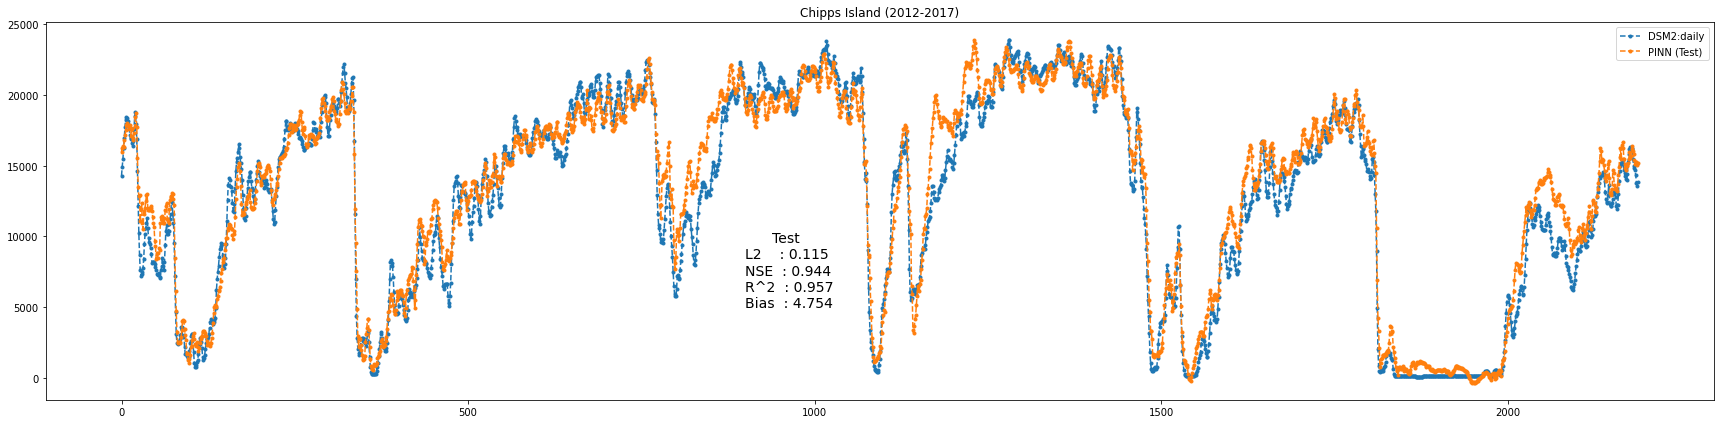

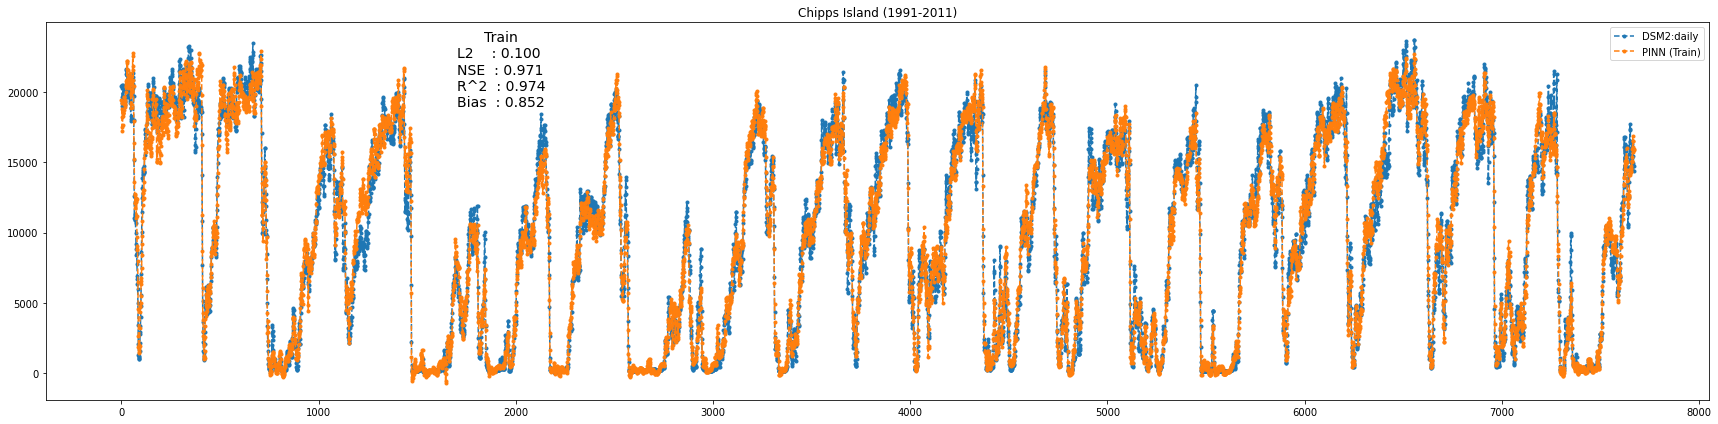

In [15]:
'''
Plot time series of salinity estimated by PINN at three locations
'''

portion = 1 / (len(tr_indices) + len(tst_indices)) # to split the time domain [0, 1] uniformly

## At Martinez

# Test plot
P = []

for i in range(len(tst_EC_d)):
    cur_ind = tst_indices[i]
    P.append(np.concatenate(([0, (cur_ind - 274) * portion], M_OUT[cur_ind-275, :])))

P = np.array(P)

test_results = evaluate_sequences(tst_EC_d[:, 0][:, None], model.predict(P), eval_metrics)
print("PINN results for testing at Martinez")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

fig1 = pl.figure(1, figsize=(24,6))
pl.plot(tst_EC_d[:, 0] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='PINN (Test)')
pl.text(900, 5000, '      Test\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (test_results['L2'], test_results['NSE'], test_results['R']**2, test_results['Bias']), fontsize=14)
pl.legend()
pl.title('Martinez (2012-2017)')
pl.tight_layout()

# Train plot
P = []

for i in range(len(tr_EC_d)):
    cur_ind = tr_indices[i]
    P.append(np.concatenate(([0, (cur_ind - 274) * portion], M_OUT[cur_ind-275, :])))

P = np.array(P)

train_results = evaluate_sequences(tr_EC_d[:, 0][:, None], model.predict(P), eval_metrics)
print("PINN results for training at Martinez")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])

fig2 = pl.figure(2, figsize=(24,6))
pl.plot(tr_EC_d[:, 0] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='PINN (Train)')
pl.text(1700, 20000, '      Train\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (train_results['L2'], train_results['NSE'], train_results['R']**2, train_results['Bias']), fontsize=14)
pl.legend()
pl.title('Martinez (1991-2011)')
pl.tight_layout()

## At Port Chicago

# Test plot
P = []

for i in range(len(tst_EC_d)):
    cur_ind = tst_indices[i]
    P.append(np.concatenate(([0.442, (cur_ind - 274) * portion], P_OUT[cur_ind-275, :])))

P = np.array(P)

test_results = evaluate_sequences(tst_EC_d[:, 1][:, None], model.predict(P), eval_metrics)
print("PINN results for testing at Port Chicago")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

fig3 = pl.figure(3, figsize=(24,6))
pl.plot(tst_EC_d[:, 1] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='PINN (Test)')
pl.text(900, 5000, '      Test\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (test_results['L2'], test_results['NSE'], test_results['R']**2, test_results['Bias']), fontsize=14)
pl.legend()
pl.title('Port Chicago (2012-2017)')
pl.tight_layout()

# Train plot
P = []

for i in range(len(tr_EC_d)):
    cur_ind = tr_indices[i]
    P.append(np.concatenate(([0.442, (cur_ind - 274) * portion], P_OUT[cur_ind-275, :])))

P = np.array(P)

train_results = evaluate_sequences(tr_EC_d[:, 1][:, None], model.predict(P), eval_metrics)
print("PINN results for training at Port Chicago")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])

fig4 = pl.figure(4, figsize=(24,6))
pl.plot(tr_EC_d[:, 1] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='PINN (Train)')
pl.text(1700, 17000, '      Train\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (train_results['L2'], train_results['NSE'], train_results['R']**2, train_results['Bias']), fontsize=14)
pl.legend()
pl.title('Port Chicago (1991-2011)')
pl.tight_layout()

## At Chipps Island

# Test plot
P = []

for i in range(len(tst_EC_d)):
    cur_ind = tst_indices[i]
    P.append(np.concatenate(([1, (cur_ind - 274) * portion], C_OUT[cur_ind-275, :])))

P = np.array(P)

test_results = evaluate_sequences(tst_EC_d[:, 2][:, None], model.predict(P), eval_metrics)
print("PINN results for testing at Chipps Island")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

fig5 = pl.figure(5, figsize=(24,6))
pl.plot(tst_EC_d[:, 2] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='PINN (Test)')
pl.text(900, 5000, '      Test\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (test_results['L2'], test_results['NSE'], test_results['R']**2, test_results['Bias']), fontsize=14)
pl.legend()
pl.title('Chipps Island (2012-2017)')
pl.tight_layout()

# Train plot
P = []

for i in range(len(tr_EC_d)):
    cur_ind = tr_indices[i]
    P.append(np.concatenate(([1, (cur_ind - 274) * portion], C_OUT[cur_ind-275, :])))

P = np.array(P)

train_results = evaluate_sequences(tr_EC_d[:, 2][:, None], model.predict(P), eval_metrics)
print("PINN results for training at Chipps Island")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])

fig6 = pl.figure(6, figsize=(24,6))
pl.plot(tr_EC_d[:, 2] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='PINN (Train)')
pl.text(1700, 19000, '      Train\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (train_results['L2'], train_results['NSE'], train_results['R']**2, train_results['Bias']), fontsize=14)
pl.legend()
pl.title('Chipps Island (1991-2011)')
pl.tight_layout()

In [16]:
fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Martinez_test")
fig1.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Martinez_train")
fig2.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Port Chicago_test")
fig3.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Port Chicago_train")
fig4.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Chipps Island_test")
fig5.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Chipps Island_train")
fig6.savefig(fig_savepath, bbox_inches='tight',dpi=300)

### ANN for comparison

Same hyperparamters as PINN

In [166]:
## Train model

model = keras.Sequential(
        [
            keras.layers.Input(shape=(18,)),
            keras.layers.Dense(28, activation='relu'),
            keras.layers.Dense(6, activation='elu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

history = model.fit(Q, Svals,
                        epochs=5000,
                        batch_size=len(Q),
                        validation_data=(Q_tst, Svals_tst),
                        callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                patience=50,
                                                                mode="min",
                                                                restore_best_weights=True),
                                ],
                    )

Train on 23010 samples, validate on 6567 samples
Epoch 1/5000
23001/23010 [============================>.] - ETA: 0s - loss: 0.0877

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


23010/23010 [==============================] - 4s 160us/sample - loss: 0.0877 - val_loss: 0.0755
Epoch 2/5000
23010/23010 [==============================] - 0s 1us/sample - loss: 0.0854 - val_loss: 0.0750
Epoch 3/5000
23010/23010 [==============================] - 0s 1us/sample - loss: 0.0836 - val_loss: 0.0745
Epoch 4/5000
23010/23010 [==============================] - 0s 1us/sample - loss: 0.0820 - val_loss: 0.0741
Epoch 5/5000
23010/23010 [==============================] - 0s 1us/sample - loss: 0.0804 - val_loss: 0.0738
Epoch 6/5000
23010/23010 [==============================] - 0s 1us/sample - loss: 0.0788 - val_loss: 0.0735
Epoch 7/5000
23010/23010 [==============================] - 0s 1us/sample - loss: 0.0772 - val_loss: 0.0733
Epoch 8/5000
23010/23010 [==============================] - 0s 1us/sample - loss: 0.0755 - val_loss: 0.0732
Epoch 9/5000
23010/23010 [==============================] - 0s 1us/sample - loss: 0.0740 - val_loss: 0.0732
Epoch 10/5000
23010/23010 [============

In [57]:
## Save model
model_path_prefix = "ANN_chrono_first"
model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
model.save(model_savepath)
print('Model saved to %s' % model_savepath)

Model saved to /content/drive/My Drive/PINN/models/ANN_chrono_first


In [169]:
# ## Load model (if saved already)
# model_path_prefix = "ANN_chrono_first"
# model_savepath = os.path.join(gdrive_root_path, 'models', (model_path_prefix))
# model = keras.models.load_model(model_savepath)

In [170]:
## Evaluation results

train_results = evaluate_sequences(Svals, model.predict(Q),  eval_metrics)
test_results = evaluate_sequences(Svals_tst, model.predict(Q_tst), eval_metrics)

print("ANN results for training")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])
print("\n")
print("ANN results for testing")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


ANN results for training
------------------------------
MSE : 0.009960626
Bias : 3.0748188495635986
R : 0.9472575566545006
RMSD : 0.08798175867105117
NSE : 0.8690419346094131
L2 : 0.2135586


ANN results for testing
------------------------------
MSE : 0.011712684
Bias : -2.73300614207983
R : 0.9393914784362751
RMSD : 0.09550706418484867
NSE : 0.8498036712408066
L2 : 0.19149366


ANN results for testing at Martinez
------------------------------
MSE : 0.016045154209975012
Bias : -15.33071368458506
R : 0.9602241996788343
RMSD : 0.10435747552398279
NSE : 0.8100948280903595
L2 : 0.19942520384430076
ANN results for training at Martinez
------------------------------
MSE : 0.010308968135457739
Bias : -12.184474538365206
R : 0.9642516448070461
RMSD : 0.0960069182210424
NSE : 0.8811195797530031
L2 : 0.19083081181619876
ANN results for testing at Port Chicago
------------------------------
MSE : 0.011324882130780702
Bias : 14.30468431821629
R : 0.9492005797038231
RMSD : 0.08508023897772177
NSE : 0.8228624755570298
L2 : 0.21781150633886726
ANN results for training at Port Chicago
------------------------------
MSE : 0.013012678770109075
Bias : 24.110823110105613
R : 0.9579424237536247
RMSD : 0.07792655293393458
NSE : 0.7823759245158123
L2 : 0.28703511510359414
ANN results for testing at Chipps Island
------------------------------
MSE : 0.0077680178281692245
Bias : -2.7

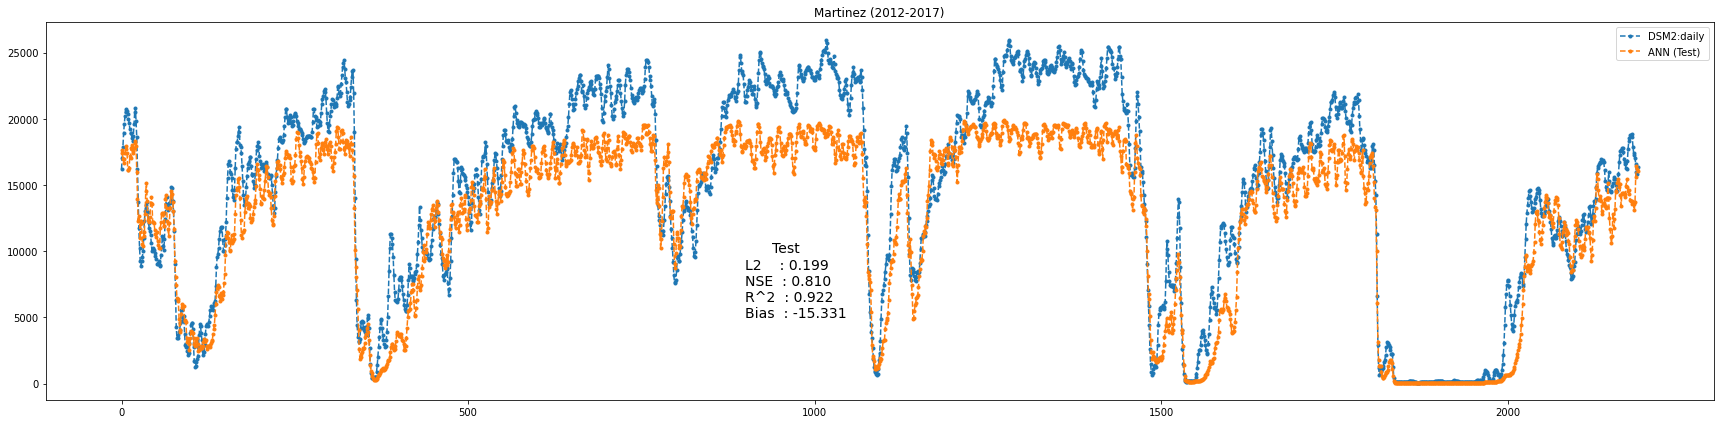

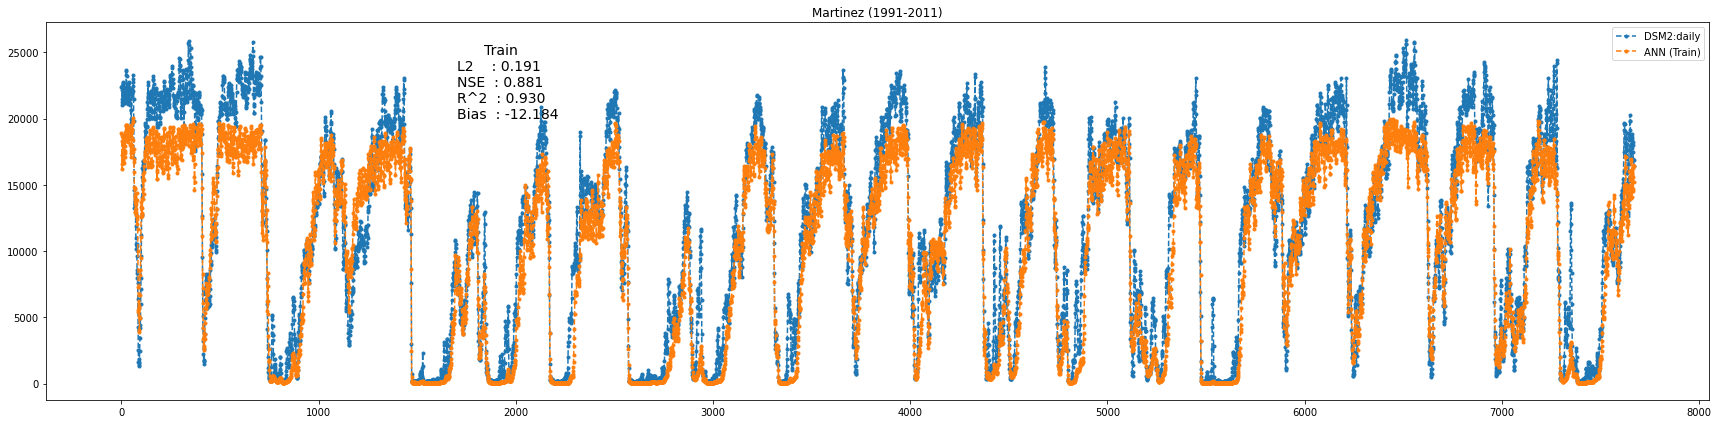

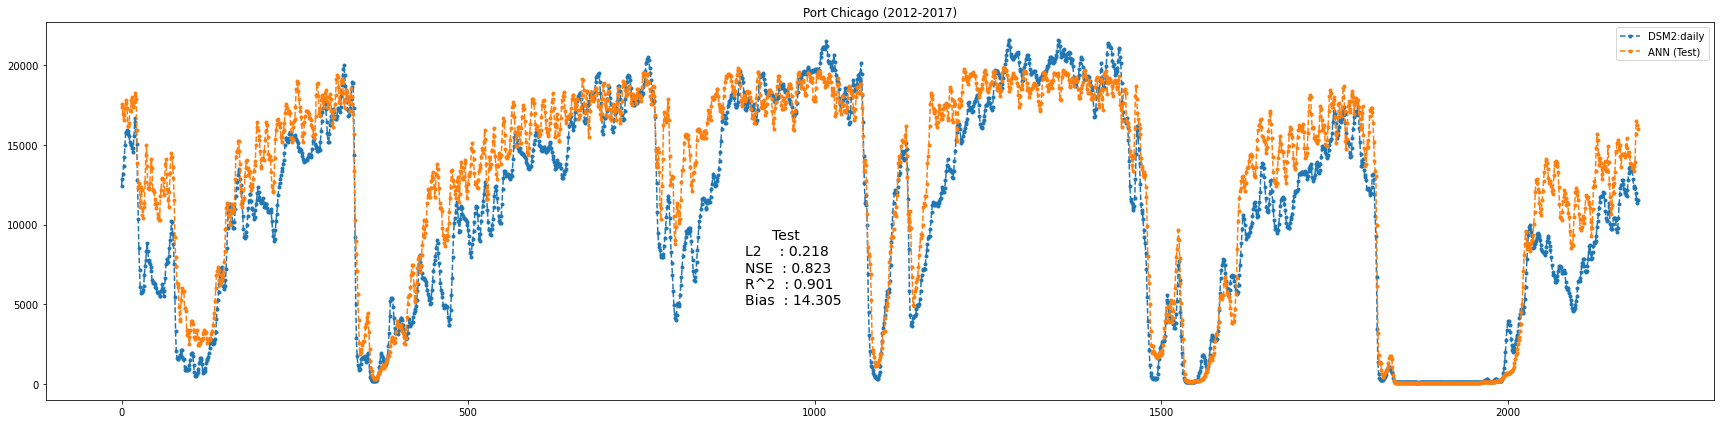

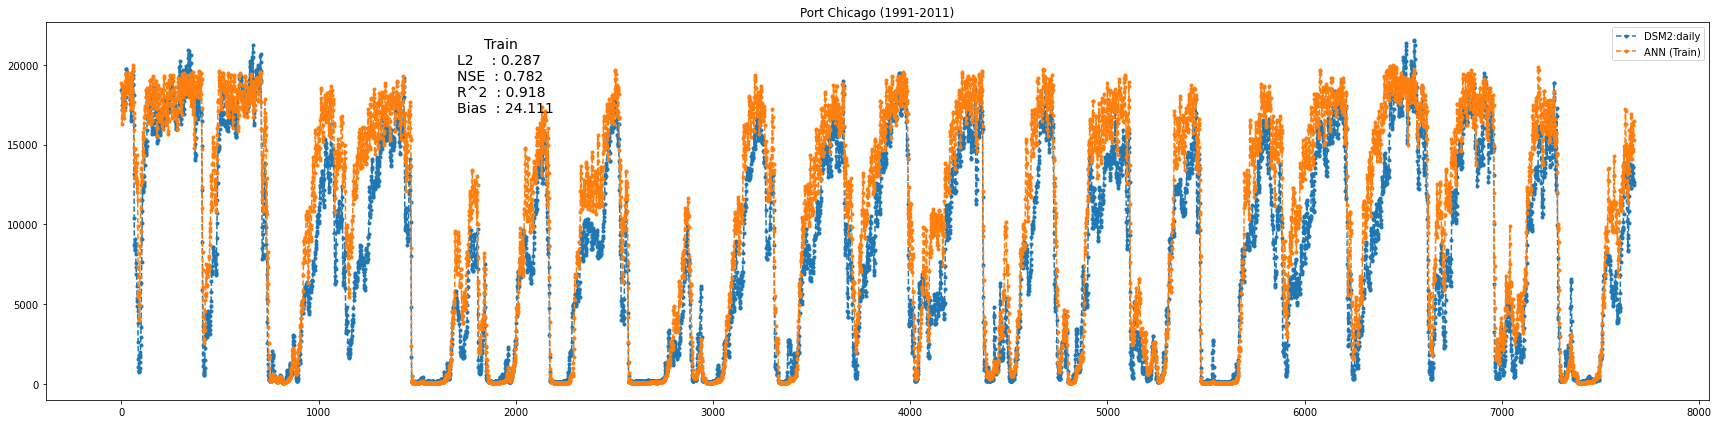

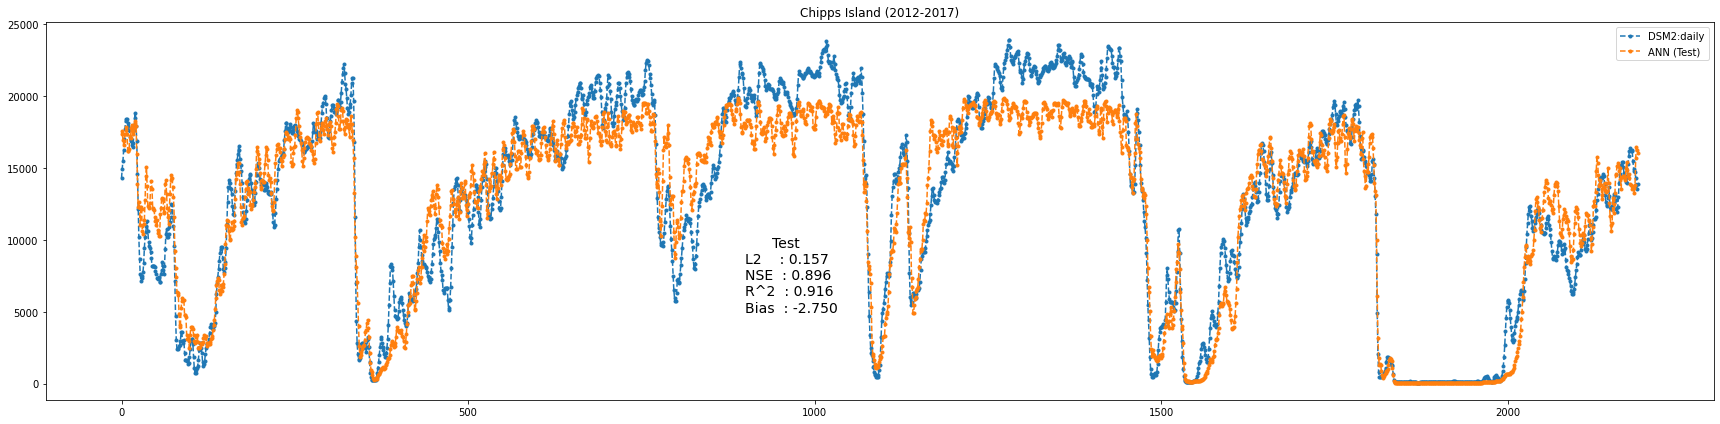

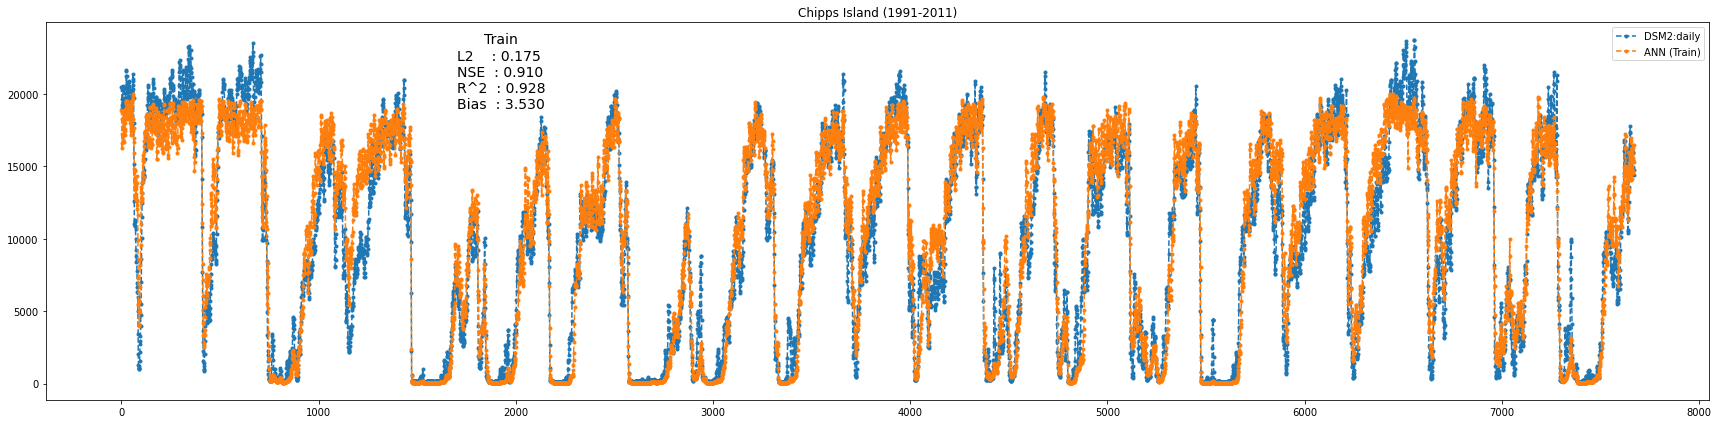

In [173]:
'''
Plot time series of salinity estimated by ANN at three locations
'''

## At Martinez

# Test plot
P = []

for i in range(len(tst_EC_d)):
    cur_ind = tst_indices[i]
    P.append(M_OUT[cur_ind-275, :])

P = np.array(P)

test_results = evaluate_sequences(tst_EC_d[:, 0][:, None], model.predict(P), eval_metrics)
print("ANN results for testing at Martinez")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

fig1 = pl.figure(1, figsize=(24,6))
pl.plot(tst_EC_d[:, 0] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='ANN (Test)')
pl.text(900, 5000, '      Test\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (test_results['L2'], test_results['NSE'], test_results['R']**2, test_results['Bias']), fontsize=14)
pl.legend()
pl.title('Martinez (2012-2017)')
pl.tight_layout()

# Train plot
P = []

for i in range(len(tr_EC_d)):
    cur_ind = tr_indices[i]
    P.append(M_OUT[cur_ind-275, :])

P = np.array(P)

train_results = evaluate_sequences(tr_EC_d[:, 0][:, None], model.predict(P), eval_metrics)
print("ANN results for training at Martinez")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])

fig2 = pl.figure(2, figsize=(24,6))
pl.plot(tr_EC_d[:, 0] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='ANN (Train)')
pl.text(1700, 20000, '      Train\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (train_results['L2'], train_results['NSE'], train_results['R']**2, train_results['Bias']), fontsize=14)
pl.legend()
pl.title('Martinez (1991-2011)')
pl.tight_layout()

## At Port Chicago

# Test plot
P = []

for i in range(len(tst_EC_d)):
    cur_ind = tst_indices[i]
    P.append(P_OUT[cur_ind-275, :])

P = np.array(P)

test_results = evaluate_sequences(tst_EC_d[:, 1][:, None], model.predict(P), eval_metrics)
print("ANN results for testing at Port Chicago")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

fig3 = pl.figure(3, figsize=(24,6))
pl.plot(tst_EC_d[:, 1] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='ANN (Test)')
pl.text(900, 5000, '      Test\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (test_results['L2'], test_results['NSE'], test_results['R']**2, test_results['Bias']), fontsize=14)
pl.legend()
pl.title('Port Chicago (2012-2017)')
pl.tight_layout()

# Train plot
P = []

for i in range(len(tr_EC_d)):
    cur_ind = tr_indices[i]
    P.append(P_OUT[cur_ind-275, :])

P = np.array(P)

train_results = evaluate_sequences(tr_EC_d[:, 1][:, None], model.predict(P), eval_metrics)
print("ANN results for training at Port Chicago")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])

fig4 = pl.figure(4, figsize=(24,6))
pl.plot(tr_EC_d[:, 1] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='ANN (Train)')
pl.text(1700, 17000, '      Train\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (train_results['L2'], train_results['NSE'], train_results['R']**2, train_results['Bias']), fontsize=14)
pl.legend()
pl.title('Port Chicago (1991-2011)')
pl.tight_layout()

## At Chipps Island

# Test plot
P = []

for i in range(len(tst_EC_d)):
    cur_ind = tst_indices[i]
    P.append(C_OUT[cur_ind-275, :])

P = np.array(P)

test_results = evaluate_sequences(tst_EC_d[:, 2][:, None], model.predict(P), eval_metrics)
print("ANN results for testing at Chipps Island")
print("-" * 30)
for metric in test_results:
    print(metric, ':', test_results[metric])

fig5 = pl.figure(5, figsize=(24,6))
pl.plot(tst_EC_d[:, 2] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='ANN (Test)')
pl.text(900, 5000, '      Test\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (test_results['L2'], test_results['NSE'], test_results['R']**2, test_results['Bias']), fontsize=14)
pl.legend()
pl.title('Chipps Island (2012-2017)')
pl.tight_layout()

# Train plot
P = []

for i in range(len(tr_EC_d)):
    cur_ind = tr_indices[i]
    P.append(C_OUT[cur_ind-275, :])

P = np.array(P)

train_results = evaluate_sequences(tr_EC_d[:, 2][:, None], model.predict(P), eval_metrics)
print("ANN results for training at Chipps Island")
print("-" * 30)
for metric in train_results:
    print(metric, ':', train_results[metric])

fig6 = pl.figure(6, figsize=(24,6))
pl.plot(tr_EC_d[:, 2] * (EC_max - EC_min) + EC_min, color='#1f77b4', marker='.', linestyle='dashed', label='DSM2:daily')
pl.plot(model.predict(P)[:, 0] * (EC_max - EC_min) + EC_min, color='#ff7f0e', marker='.', linestyle='dashed', label='ANN (Train)')
pl.text(1700, 19000, '      Train\nL2    : %.3f\nNSE  : %.3f\nR^2  : %.3f\nBias  : %.3f' % (train_results['L2'], train_results['NSE'], train_results['R']**2, train_results['Bias']), fontsize=14)
pl.legend()
pl.title('Chipps Island (1991-2011)')
pl.tight_layout()

In [174]:
## Save plots

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Martinez_test")
fig1.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Martinez_train")
fig2.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Port Chicago_test")
fig3.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Port Chicago_train")
fig4.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Chipps Island_test")
fig5.savefig(fig_savepath, bbox_inches='tight',dpi=300)

fig_savepath = os.path.join(gdrive_root_path, "images/PINN_Best_param", (model_path_prefix) + "_Chipps Island_train")
fig6.savefig(fig_savepath, bbox_inches='tight',dpi=300)